<a href="https://www.kaggle.com/code/ksetdekov/coffee-amount-optimization?scriptVersionId=231761062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Ноутбук для подбора количества кофе, которое минимизирует стресс

## main class

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
from datetime import datetime, timedelta
import operator
from functools import reduce

def combiner_times(time_list: list):
    """takes a list of times and returns a string in the format hh:mm:ss that is a sum of the times
    Args:
        time_list (list): a list of times in the format hh:mm:ss
    Returns:
        str: a string in the format hh:mm:ss that is a sum of the times
    """
    time_list = [pd.to_timedelta(x) for x in time_list]
    
    total_time = reduce(operator.add, time_list)
    # return total time in the format hh:mm:ss
    total_time_str = str(total_time).split()[2]
    return total_time_str

class HandsTable():
    minimize = True
    rho = 3.37

    def __init__(self, options_list, minimize=True, rho=1.0):
        """инициализация

        Args:
            options_list (list): список из названий
            minimize (bool, optional): Минимизировать если True, максимизировать если False. Defaults to True.
            rho (float, optional): Риск толерантность, чем больше, тем больше риска готовы принять. Defaults to 1.0.
        """
        self.hands = pd.DataFrame({'name': options_list,
                                   'mu': 0.0,
                                   'Te': 0.0,
                                   'alpha': 0.5,
                                   'beta': 0.5
                                   })
        self.minimize = minimize
        if rho is not None:
            self.rho = rho

        self.history = pd.DataFrame(columns=['option', 'value'])

    @classmethod
    def to_minutes(cls, timestr: str):
        '''
        convert timestr to float minutes
        '''
        return pd.to_timedelta(timestr).total_seconds()/60

    @classmethod
    def update_mean(cls, X, T_last, mu_last):
        mu_new = T_last * mu_last / (T_last + 1) + X / (T_last + 1)
        return mu_new

    @classmethod
    def update_samples(cls, T):
        return T + 1

    @classmethod
    def update_shape(cls, a):
        return a + 0.5

    @classmethod
    def update_rate(cls, X, mu_last, beta_last, T_last):
        beta_new = beta_last + (T_last / (T_last + 1)) * \
            (np.square(X - mu_last)) / 2
        return beta_new

    def update_hands(self, name, value):
        if isinstance(value, str):
            try:
                value = HandsTable.to_minutes(value)
            except ValueError:
                raise ValueError('input time string in hh:mm:ss format')
        elif isinstance(value, float) or isinstance(value, int):
            pass
        else:
            raise ValueError('input time string or int/float value')

        _, mu, t, alpha, beta = self.hands[self.hands.name == name].values[0]
        beta = HandsTable.update_rate(value, mu, beta, t)
        mu = HandsTable.update_mean(value, t, mu)
        t = HandsTable.update_samples(t)
        alpha = HandsTable.update_shape(alpha)

        # added code to write history
        self.history.loc[len(self.history.index)] = [name, value]

        self.hands.loc[self.hands.name == name, 'mu'] = mu
        self.hands.loc[self.hands.name == name, 'Te'] = t
        self.hands.loc[self.hands.name == name, 'alpha'] = alpha
        self.hands.loc[self.hands.name == name, 'beta'] = beta

    def grade(self):
        hands_output = self.hands.copy()
        tau = gamma.rvs(a=hands_output.alpha, scale=1/hands_output.beta)
        theta_drops = norm.rvs(hands_output.mu, 1/hands_output.Te)
        hands_output['tau'] = tau
        hands_output['theta'] = theta_drops
        hands_output['SD'] = np.sqrt(1/tau)

        if self.minimize == True:
            hands_output['var95'] = theta_drops + \
                norm.ppf(1-0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:

                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops + 1/tau))
        else:
            hands_output['var95'] = theta_drops + \
                norm.ppf(0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:
                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops - 1/tau)[::-1])

        return output_df

    def process_events(self, events, days=91):
        """Filter events and update hands"""
        oldest_ok = max(events) - timedelta(days=days)
        filtered_events = {k: v for k, v in events.items() if k > oldest_ok}

        for category, value in filtered_events.values():
            self.update_hands(category, value)
        return self.grade()

    def __str__(self):
        return repr(self.hands)

# Применение

In [14]:
time_total_commute = HandsTable(options_list=['moped', 'motorcycle', 'МЦК'], minimize=True, rho=1)
time_morning_commute = HandsTable(options_list=['moped', 'motorcycle', 'МЦК'], minimize=True, rho=1)
time_evening_commute = HandsTable(options_list=['moped', 'motorcycle', 'МЦК'], minimize=True, rho=1)

events_commute_all = {
    datetime(2025, 4, 2): ('moped', {'morning':'00:53:17', 'evening':'00:48:07'}),
    datetime(2025, 4, 3): ('МЦК', {'morning':'0:47:39', 'evening':'1:03:14'}),
    datetime(2025, 4, 4): ('moped', {'morning':'00:46:40'}),
    datetime(2025, 4, 7): ('МЦК', {'morning':'00:46:54', 'evening':'00:44:55'}),
    datetime(2025, 4, 8): ('МЦК', {'morning':'00:46:36'}),
    datetime(2025, 4, 9): ('МЦК', {'morning':'00:46:40'}),
    datetime(2025, 4, 11): ('МЦК', {'morning':'00:48:51'}),
    datetime(2025, 4, 18): ('МЦК', {'morning':'00:48:44'}),
    datetime(2025, 4, 22): ('МЦК', {'morning':'00:50:16'}),
    datetime(2025, 4, 22): ('МЦК', {'morning':'00:47:04', 'evening':'00:45:38'}),
    datetime(2025, 4, 22): ('МЦК', {'morning':'00:47:42'})

}
# for events_commute, we choose only the days, that have both morning and evening and summ them using combiner_times    
events_commute = {}
events_morning = {}
events_evening = {}
for date, (category, times) in events_commute_all.items():
    if 'morning' in times and 'evening' in times:
        events_commute[date] = (category, combiner_times([times['morning'], times['evening']]))
        events_morning[date] = (category, times['morning'])
        events_evening[date] = (category, times['evening'])
    elif 'morning' in times:
        events_morning[date] = (category, times['morning'])
    elif 'evening' in times:
        events_evening[date] = (category, times['evening'])
    else:
        raise ValueError('no morning or evening times')





# commute times sampled

In [15]:

oldest_ok_commute = max(events_commute)-timedelta(days=360)
print(f'oldest_ok_commute: {oldest_ok_commute}')

# Process events within the class
time_total_commute.process_events(events_commute, days=360)

oldest_ok_commute: 2024-04-12 00:00:00


,name,mu,Te,alpha,beta,tau,theta,SD,var95
Te,,,,,,,,,
1,motorcycle,0.00,0.0,0.5,0.500000,0.645556,inf,1.24461,inf
0,moped,101.40,1.0,1.0,0.500000,1.023009,101.998009,0.98869,103.935807
2,МЦК,101.35,2.0,1.5,91.384444,0.036125,101.478599,5.26132,111.790598


In [16]:
# Process morning commute events
time_morning_commute.process_events(events_morning, days=360)


,name,mu,Te,alpha,beta,tau,theta,SD,var95
Te,,,,,,,,,
1,motorcycle,0.000000,0.0,0.5,0.500000,0.137728,inf,2.694570,inf
0,moped,49.975000,2.0,1.5,11.445069,0.401999,50.311924,1.577203,53.403185
2,МЦК,47.585714,7.0,4.0,3.109563,1.022643,47.418914,0.988867,49.357059


In [17]:

# Process evening commute events
time_evening_commute.process_events(events_evening, days=360)

,name,mu,Te,alpha,beta,tau,theta,SD,var95
Te,,,,,,,,,
1,motorcycle,0.000000,0.0,0.5,0.500000,0.648878,inf,1.241419,inf
0,moped,48.116667,1.0,1.0,0.500000,0.465167,49.412923,1.466207,52.286636
2,МЦК,54.075000,2.0,1.5,84.375069,0.002177,54.441161,21.430953,96.445057


# commute times

100%|██████████| 10000/10000 [00:11<00:00, 905.24it/s]


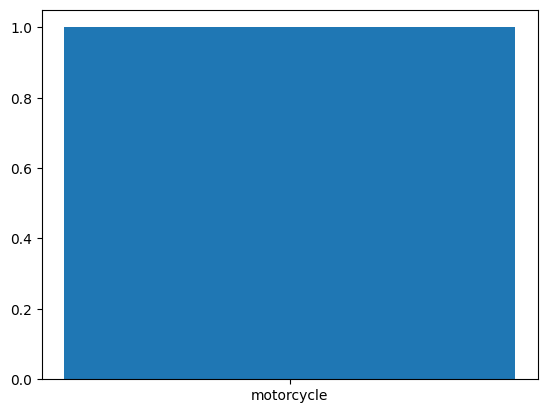

,variant,prob
0,motorcycle,1.0


In [18]:

results = defaultdict(int)
for i in tqdm(range(10000)):
    i_res = time_total_commute.grade()
    i_var = i_res.iloc[0]['name']
    results[i_var] += 1

variants_proba_current = pd.DataFrame(results.items(), columns=['variant', 'prob'])
variants_proba_current['prob'] = variants_proba_current['prob']/sum(variants_proba_current['prob'])
variants_proba_current = variants_proba_current.sort_values('variant')

plt.bar(variants_proba_current['variant'], variants_proba_current['prob'], align='center')

plt.show()
variants_proba_current

In [19]:

fig = px.violin(time_total_commute.history, y="value", x="option", box=True, points="all",
          hover_data=time_total_commute.history.columns)
fig.show()

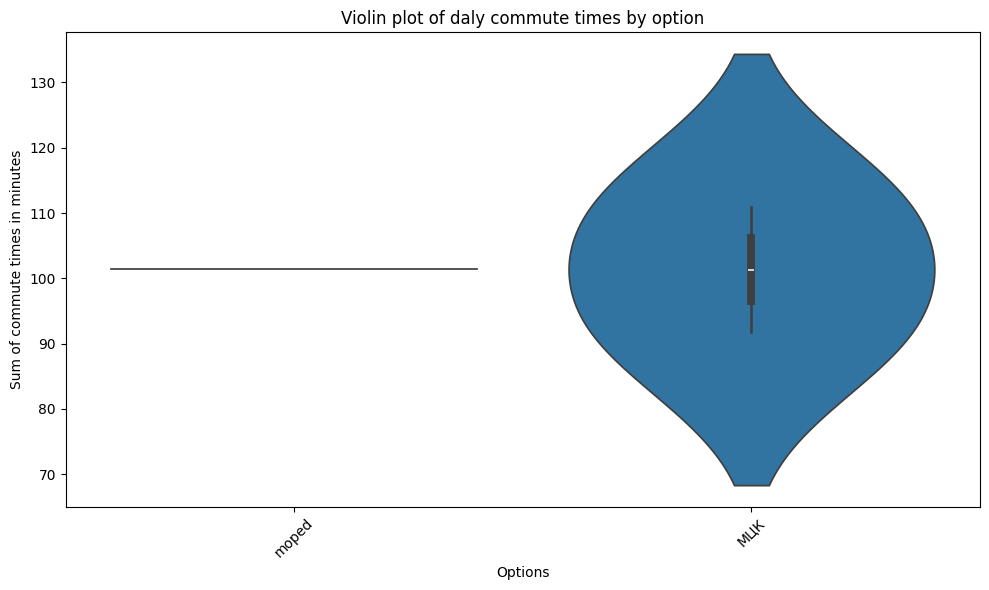

In [20]:

grouped_data = [group['value'].values for name, group in time_total_commute.history.groupby('option')]
fix, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='option', y='value', data=time_total_commute.history, ax=ax)
# set y axis to be in the format hh:mm:ss
ax.set_title('Violin plot of daly commute times by option')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Options')
ax.set_ylabel('Sum of commute times in minutes')
plt.tight_layout()
plt.show()

# Какой выход из МЦК утром?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода на платформу до выхода из крутящихся дверей офиса


In [21]:
morning_exit = HandsTable(options_list=["мцк","мцд эскалатор", "мцд пешком"], minimize=True)
# 3 мцк
# 6 мцд эскалатор
morning_exit.update_hands("мцк", '0:08:03.7') # вторник 19 ноября
morning_exit.update_hands("мцд эскалатор", '0:08:40') # среда 20 ноября
morning_exit.update_hands("мцк", '0:09:23.4') # mon 25 ноября
morning_exit.update_hands("мцд эскалатор", '0:07:46.5') # вторник 26 ноября
morning_exit.update_hands("мцд эскалатор", '0:07:27.9') # среда 27 ноября
morning_exit.update_hands("мцк", '0:09:11') # пятница 29 ноября
morning_exit.update_hands("мцд эскалатор", '0:08:17.6') # понедельник 2 декабря
morning_exit.update_hands("мцд эскалатор", '0:08:28.4') # вторник 3 декабря
morning_exit.update_hands("мцд эскалатор", '0:08:28.4') # wed 4 dec
morning_exit.update_hands("мцд эскалатор", '0:07:26') # th 5 dec
morning_exit.update_hands("мцд эскалатор", '0:08:46.4') # fr 6 dec
morning_exit.update_hands("мцд эскалатор", '0:08:51.5') # mon 9 dec
morning_exit.update_hands("мцд эскалатор", '0:07:54.6') # th 12 dec
morning_exit.update_hands("мцд эскалатор", '0:08:05.6') # fr 13 dec
morning_exit.update_hands("мцд эскалатор", '0:08:37') # пн 16 dec
morning_exit.update_hands("мцд эскалатор", '0:07:38.9') # tue 17 dec
morning_exit.update_hands("мцк", '0:08:59.2') # wed 18 dec
morning_exit.update_hands("мцд эскалатор", '0:07:27.7') # th 19 dec
morning_exit.update_hands("мцд эскалатор", '0:07:56.5') # fr 20 dec
morning_exit.update_hands("мцд эскалатор", '0:07:26.32') # mon 23 dec
morning_exit.update_hands("мцд эскалатор", '0:09:09.3') # tue 24 dec
morning_exit.update_hands("мцд эскалатор", '0:07:53.2') # wed 25 dec
morning_exit.update_hands("мцд эскалатор", '0:07:32.9') # thr 26 dec
morning_exit.update_hands("мцд эскалатор", '0:07:06.4') # thr 09 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:12.6') # fr 10 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:39.3') # mon 13 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:54.4') # tue 14 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:47.1') # wed 15 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:24.0') # thr 16 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:15.4') # fr 17 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:04.1') # mon 20 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:52.4') # tue 21 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:40.0') # wed 22 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:21.0') # thr 23 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:50.5') # fr 24 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:11.1') # mon 27 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:21.52') # tue 28 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:26.8') # wed 29 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:01.8') # thr 30 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:14.0') # mon 3 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:51.4') # tue 4 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:53') # wed 5 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:05') # thr 6 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:26.8') # fr 7 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:27.8') # monday 10 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:58.9') # tue 11 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:24.6') # wed 12 feb 2025
morning_exit.update_hands("мцд пешком", '0:07:47.1') # thr 13 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:54.1') # fr 14 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:59.6') # mon 17 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:53.3') # tue 18 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:04.7') # wed 19 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:15.3') # thr 20 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:37.7') # fr 21 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:18.5') # tue 25 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:12.0') # fr 28 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:39.4') # mon 10 march 2025
morning_exit.update_hands("мцд эскалатор", '0:08:17.5') # wed 12 march 2025
morning_exit.update_hands("мцд эскалатор", '0:07:31.4') # thr 13 march 2025
morning_exit.update_hands("мцд эскалатор", '0:07:40.8') # fr 14 march 2025


morning_exit.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
1,мцд эскалатор,8.027791,51.0,26.0,6.689018,3.772800,8.021899,0.514835,9.030957
2,мцд пешком,8.236667,5.0,3.0,0.677297,4.002873,8.310730,0.499821,9.290361
0,мцк,8.905417,4.0,2.5,1.015287,1.047093,8.978595,0.977254,10.893977


In [22]:
fig = px.violin(morning_exit.history, y="value", x="option", box=True, points="all",
          hover_data=morning_exit.history.columns)
fig.show()

# Какой вход в МЦК вечером?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода из крутящихся дверей до посадки в поезд


In [23]:
evening_entrance = HandsTable(options_list=["мцк","мцд эскалатор", "мцд пешком"], minimize=True)
# 3 мцк
# 6 мцд эскалатор
evening_entrance.update_hands("мцд эскалатор", '0:08:03.7') # четверг 21 ноября
evening_entrance.update_hands("мцк", '0:11:14') # четверг 28 ноября
evening_entrance.update_hands("мцд эскалатор", '0:15:47.8') # понедельник 2 декабря
evening_entrance.update_hands("мцк", '0:11:03') # tue 3 dec
evening_entrance.update_hands("мцк", '0:14:29.3') # wed 4 dec
evening_entrance.update_hands("мцк", '0:12:05') # fr 06 dec
evening_entrance.update_hands("мцк", '0:13:53') # mon 09 dec
evening_entrance.update_hands("мцд эскалатор", '0:10:14') # fr 13 декабря
evening_entrance.update_hands("мцк", '0:09:31.7') # tue 17 dec
evening_entrance.update_hands("мцк", '0:08:33') # wed 18 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:51.9') # th 19 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:16.1') # mon 23 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:31.7') # tue 24 dec
evening_entrance.update_hands("мцк", '0:08:19.6') # wed 18 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:18.6') # th 9 jan
evening_entrance.update_hands("мцк", '0:08:11.9') # fr 10 jan
evening_entrance.update_hands("мцд эскалатор", '0:10:50') # mon 13 jan
evening_entrance.update_hands("мцд эскалатор", '0:11:15') # tue 14 jan
evening_entrance.update_hands("мцк", '0:12:08') # wed 15 jan
evening_entrance.update_hands("мцк", '0:10:13') # mon 20 jan
evening_entrance.update_hands("мцд эскалатор", '0:11:40') # tue 21 jan
evening_entrance.update_hands("мцк", '0:15:48') # wed 22 jan
evening_entrance.update_hands("мцд эскалатор", '0:09:34.7') # thr 23 jan
evening_entrance.update_hands("мцд пешком", '0:10:45') # thr 6 feb
evening_entrance.update_hands("мцд пешком", '0:12:01') # fr 7 feb
evening_entrance.update_hands("мцд пешком", '0:10:34') # monday 10 feb
evening_entrance.update_hands("мцд пешком", '0:09:08.2') # thr 13 feb
evening_entrance.update_hands("мцд пешком", '0:09:57.6') # fr 14 feb
evening_entrance.update_hands("мцд пешком", '0:09:46.8') # mon 17 feb
evening_entrance.update_hands("мцд пешком", '0:15:38') # wed 19 feb
evening_entrance.update_hands("мцд пешком", '0:11:49') # thr 20 feb
evening_entrance.update_hands("мцд пешком", '0:10:35') # thr 27 feb
evening_entrance.update_hands("мцд эскалатор", '0:11:57.0') # mon 10 march
evening_entrance.update_hands("мцд эскалатор", '0:10:17.0') # tue 11 march
evening_entrance.update_hands("мцд пешком", '0:11:22.0') # thr 13 march

evening_entrance.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
2,мцд пешком,11.161000,10.0,5.5,15.254734,0.400760,11.296857,1.579639,14.392893
0,мцк,11.290972,12.0,6.5,34.899532,0.239527,11.243596,2.043255,15.248303
1,мцд эскалатор,10.586538,13.0,7.0,22.144001,0.182641,10.646755,2.339922,15.232919


In [24]:
fig = px.violin(evening_entrance.history, y="value", x="option", box=True, points="all",
          hover_data=evening_entrance.history.columns)
fig.show()